## Our goal to define a style of each team in Premier League (English Top Football League) and then try to predict result of a match (Win-Draw-Lose) based on opponent and its playing style.

## Dataset Description:
The dataset contains Premier League match results and team statistics, including expected goals (xG), possession, touches, and progressive play metrics. It is composed of three main sources: Matches.csv, TeamsPremierLeagueGoals.csv, and TeamsPremierLeague.csv

In [212]:
# Import and load data
import pandas as pd

teams_stats_goals = pd.read_csv("TeamsPremierLeagueGoals.csv")
teams_stats = pd.read_csv("TeamsPremierLeague.csv")
matches = pd.read_csv("Matches.csv")

## Data Mining Goals:
The project aims to define team playing styles through clustering and use these styles to classify match outcomes (Win/Draw/Loss). The key focus is on linking team tactical attributes to predictive outcomes using data mining techniques. 

## Further Steps:

#### Algorithm:
We will use KMeans clustering to define tactical styles from raw team statistics. This unsupervised learning step helps group similar team behaviors.

#### Classifier:
To predict match results, we plan to use Random Forest and potentially XGBoost, both of which are powerful ensemble classifiers capable of handling multiclass problems effectively. 

#### Evaluation:
We will evaluate the classifiers using accuracy, F1-score, and confusion matrix to assess performance across Win/Draw/Loss outcomes. To ensure reliability, we will apply k-fold cross-validation and check for class imbalance effects.

### What was already done?

In previous part of report we did all the neccessary data cleansing and preparation. Our data has no outliers that should be deleted or NA's and is ready to use. We also checked which coreleations are important and should be used in later parts. However there are some minor things we decieded to improve during the development of our model.



### Some deleted columns are needed to be restored for better accuracy in our model

In [213]:
# Drop columns that are not needed for analysis (WE RESTORED: 'Age', 'Succ', 'PrgR', 'Mis','Dis', 'Tkld')
teams_stats_goals = teams_stats_goals.drop(['MP','Starts','Min','90s'],axis=1)
teams_stats = teams_stats.drop(['90s','Live','PrgC'],axis=1)
matches = matches.drop(['Day','Date','Day Date','Year Date','Venue','Referee'],axis=1)

### Rename some columns for better readabilty 


In [214]:
matches = matches.rename(columns={
                                    'Home': 'HomeTeam',
                                    'Away': 'AwayTeam',
                                    'xG Home': 'xG_Home',
                                    'xG Away': 'xG_Away',
                                    'Month Date':'Month',
                                    'Wk': 'Week'
                            })

def time_of_day(hour):
    if hour <= 12:
        return 'Morning'
    elif hour <= 18:
        return 'Afternoon'
    else:
        return 'Evening'
    
matches['Time'] = pd.to_datetime(matches['Time'], format='%H:%M').dt.hour
matches['Time'] = matches['Time'].apply(time_of_day)

### Check additional correlations
Does touches on opponent's half have impact on scored goals?

In [215]:
combined_df = pd.merge(teams_stats_goals[['Squad', 'Gls']], 
                       teams_stats[['Squad', 'Att 3rd', 'Att Pen']],
                       on='Squad')

# Now calculate correlations
correlation_goals_touches = combined_df[['Gls', 'Att 3rd', 'Att Pen']].corr().loc['Gls']

print(correlation_goals_touches)

Gls        1.000000
Att 3rd    0.761338
Att Pen    0.781467
Name: Gls, dtype: float64


### Features Used for Team Style Clustering

#### Possession Features
These variables reflect how a team controls and progresses the ball across the field.

- **Poss** – Possession percentage  
- **Carries** – Number of ball carries  
- **TotDist** – Total distance covered while progressing the ball  
- **PrgDist** – Progressive carrying distance (toward opponent goal)  
- **Rec** – Passes received  
- **Touches** – Total touches across all zones  
- **PrgR** – Progressive passes received  
- **Age** – Average player age (indirect impact on tactical maturity and pace)  
- **Touches_Def_Pen_%** – Share of touches in defensive penalty area  
- **Touches_Def_3rd_%** – Share of touches in defensive third  
- **Touches_Mid_3rd_%** – Share of touches in midfield third  
- **Touches_Att_3rd_%** – Share of touches in attacking third  
- **Touches_Att_Pen_%** – Share of touches in attacking penalty area  

#### Defensive Features
These metrics capture a team's defensive discipline, pressure, and errors.

- **CrdY** – Yellow cards  
- **CrdR** – Red cards  
- **Dis** – Times dispossessed while in control of the ball  
- **Mis** – Miscontrolled touches  
- **Tkld** – Times tackled  
- **1/3** – Tackles or duels in the final third  
- **CPA** – Challenges under pressure or failed challenges  

#### Attacking Features
These features reflect a team’s offensive threat and efficiency in converting chances.

- **Gls** – Goals scored  
- **Ast** – Assists  
- **xG** – Expected Goals (chance quality)  
- **npxG** – Non-penalty Expected Goals  
- **xAG** – Expected Assists  
- **PK** – Penalty goals  
- **PKatt** – Penalty attempts  
- **Succ%** – Dribble success rate  
- **Att** – Dribbles attempted  
- **Succ** – Successful dribbles  
- **G+A** – Total goal contributions (Goals + Assists)  



### Team Style Clustering


In [216]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

goals_cols = ['Squad', 'Gls', 'Ast', 'xG', 'npxG', 'xAG', 'PK', 'PKatt', 'G+A', 'Age', 'CrdY', 'CrdR']
stats_cols = ['Squad', 'Poss', 'Carries', 'TotDist','Def Pen', 'Def 3rd', 'Mid 3rd', 'Att 3rd', 'Att Pen', 'PrgDist', 'Rec', 'Touches', 'PrgR', 'Dis', 'Mis', 'Tkld', '1/3', 'CPA','Succ%', 'Att', 'Succ']

combined = pd.merge(teams_stats[stats_cols], teams_stats_goals[goals_cols], on='Squad')

combined['Touches_Def_Pen_%'] = combined['Def Pen'] / combined['Touches']
combined['Touches_Def_3rd_%'] = combined['Def 3rd'] / combined['Touches']
combined['Touches_Mid_3rd_%'] = combined['Mid 3rd'] / combined['Touches']
combined['Touches_Att_3rd_%'] = combined['Att 3rd'] / combined['Touches']
combined['Touches_Att_Pen_%'] = combined['Att Pen'] / combined['Touches']

# features distribution
possession_features = ['Poss', 'Carries', 'TotDist', 'PrgDist', 'Rec', 'Touches', 'PrgR', 'Age', 'Touches_Def_Pen_%', 'Touches_Def_3rd_%', 'Touches_Mid_3rd_%',
    'Touches_Att_3rd_%', 'Touches_Att_Pen_%']
defense_features = ['CrdY', 'CrdR', 'Dis', 'Mis', 'Tkld', '1/3', 'CPA']
attack_features = ['Gls', 'Ast', 'xG', 'npxG', 'xAG', 'PK', 'PKatt', 'Succ%', 'Att', 'Succ', 'G+A']

# styles
possession_style_map = { 0: 'Direct Long Balls', 1: 'Build-Up from Back',2: 'Fast Progressive Play', 3: 'High Possession Mastery'}
defense_style_map = {0: 'High Press & Risky', 1: 'Mid Block Discipline', 2: 'Aggressive Duelers', 3: 'Balanced & Organized'}
attack_style_map = {0: 'Clinical Finishers', 1: 'Shot Volume Seekers', 2: 'Build-up with Low Threat', 3: 'Penalty Box Operators'
}

def cluster_styles(df, features, n_clusters, style_map):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    return pd.Series(labels).map(style_map), kmeans

combined['Possession_Style'], _ = cluster_styles(combined, possession_features, 4, possession_style_map)
combined['Defense_Style'], _ = cluster_styles(combined, defense_features, 4, defense_style_map)
combined['Attack_Style'], _ = cluster_styles(combined, attack_features, 4, attack_style_map)

# assign profiles
team_profiles = combined[['Squad', 'Possession_Style', 'Defense_Style', 'Attack_Style']]
print("\nTeam Tactical Profiles:\n")
print(team_profiles)



Team Tactical Profiles:

          Squad       Possession_Style         Defense_Style  \
0       Arsenal  Fast Progressive Play    High Press & Risky   
1       Arsenal  Fast Progressive Play    High Press & Risky   
2   Aston Villa      Direct Long Balls  Balanced & Organized   
3   Aston Villa      Direct Long Balls  Balanced & Organized   
4   Bournemouth     Build-Up from Back    Aggressive Duelers   
..          ...                    ...                   ...   
69    Tottenham      Direct Long Balls  Mid Block Discipline   
70     West Ham     Build-Up from Back  Mid Block Discipline   
71     West Ham     Build-Up from Back    High Press & Risky   
72       Wolves     Build-Up from Back  Mid Block Discipline   
73       Wolves     Build-Up from Back  Mid Block Discipline   

                Attack_Style  
0         Clinical Finishers  
1         Clinical Finishers  
2         Clinical Finishers  
3   Build-up with Low Threat  
4   Build-up with Low Threat  
..                 

### See what we obtain and how styles are distributed

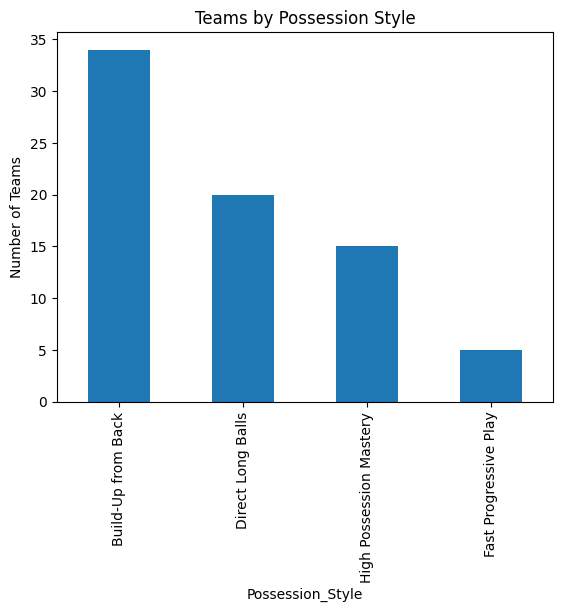

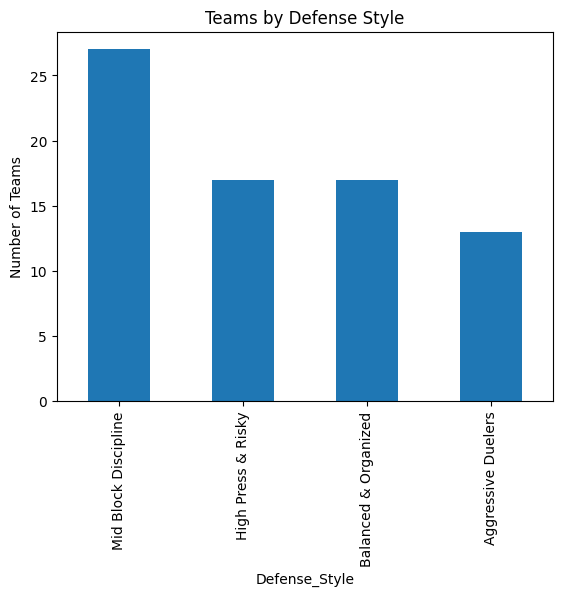

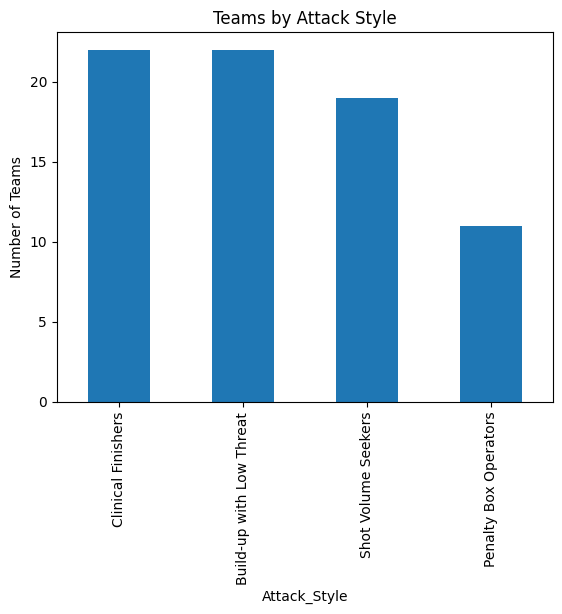

In [217]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

team_profiles['Possession_Style'].value_counts().plot(kind='bar', title='Teams by Possession Style')
plt.ylabel('Number of Teams')
plt.show()

team_profiles['Defense_Style'].value_counts().plot(kind='bar', title='Teams by Defense Style')
plt.ylabel('Number of Teams')
plt.show()

team_profiles['Attack_Style'].value_counts().plot(kind='bar', title='Teams by Attack Style')
plt.ylabel('Number of Teams')
plt.show()

### Now add team profiles to our data set

In [218]:
# Create mapping dictionaries 
possession_map = team_profiles.set_index('Squad')['Possession_Style'].to_dict()
defense_map = team_profiles.set_index('Squad')['Defense_Style'].to_dict()
attack_map = team_profiles.set_index('Squad')['Attack_Style'].to_dict()

# Apply mappings
matches['Home_Style_Pos'] = matches['HomeTeam'].map(possession_map)
matches['Home_Style_Def'] = matches['HomeTeam'].map(defense_map)
matches['Home_Style_Att'] = matches['HomeTeam'].map(attack_map)

matches['Away_Style_Pos'] = matches['AwayTeam'].map(possession_map)
matches['Away_Style_Def'] = matches['AwayTeam'].map(defense_map)
matches['Away_Style_Att'] = matches['AwayTeam'].map(attack_map)


### Create Classifier 

In [219]:

def classify_result(home_score, away_score):
    if home_score > away_score:
        return 'Home Win'
    elif home_score < away_score:
        return 'Away Win'
    else:
        return 'Draw'

matches['Result'] = matches.apply(lambda row: classify_result(row['Home_Score'], row['Away_Score']), axis=1)

matches.head()


,Week,Month,Time,HomeTeam,xG_Home,Home_Score,Away_Score,xG_Away,AwayTeam,Attendance,Season,Home_Style_Pos,Home_Style_Def,Home_Style_Att,Away_Style_Pos,Away_Style_Def,Away_Style_Att,Result
0,1,8,Evening,Burnley,0.3,0,3,1.9,Manchester City,21572.0,2024,Build-Up from Back,Aggressive Duelers,Build-up with Low Threat,High Possession Mastery,High Press & Risky,Clinical Finishers,Away Win
1,1,8,Morning,Arsenal,0.8,2,1,1.2,Nott'ham Forest,59984.0,2024,Fast Progressive Play,High Press & Risky,Clinical Finishers,Build-Up from Back,Mid Block Discipline,Penalty Box Operators,Home Win
2,1,8,Afternoon,Everton,2.7,0,1,1.5,Fulham,39940.0,2024,Build-Up from Back,Mid Block Discipline,Build-up with Low Threat,Direct Long Balls,Mid Block Discipline,Penalty Box Operators,Away Win
3,1,8,Afternoon,Sheffield Utd,0.5,0,1,1.9,Crystal Palace,31194.0,2024,Build-Up from Back,Mid Block Discipline,Penalty Box Operators,Build-Up from Back,Balanced & Organized,Build-up with Low Threat,Away Win
4,1,8,Afternoon,Brighton,4.0,4,1,1.5,Luton Town,31872.0,2024,High Possession Mastery,High Press & Risky,Clinical Finishers,Build-Up from Back,Balanced & Organized,Build-up with Low Threat,Home Win


### Split the data for training and testing
We decided to split seasons 1 for training, 1 for testing. Additionally in 2024 we need to ommit for our model teams that just got to the premier league (each season 3 teams are relegated to championship, and 3 teams are promoted), our model simply dont have data about them.

In [220]:
print(matches['Season'].dtype)

teams_2023 = set(matches[matches['Season'] == 2023]['HomeTeam']).union(
    matches[matches['Season'] == 2023]['AwayTeam']
)

train_df = matches[matches['Season'] == 2023]
test_df = matches[
    (matches['Season'] == 2024) &
    (matches['HomeTeam'].isin(teams_2023)) &
    (matches['AwayTeam'].isin(teams_2023))
]

int64


### Train and Test Random Forrest

In [221]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

style_cols = [
    'Home_Style_Pos', 'Home_Style_Def', 'Home_Style_Att',
    'Away_Style_Pos', 'Away_Style_Def', 'Away_Style_Att'
]

X_train = train_df[style_cols]
y_train = train_df['Result']

X_test = test_df[style_cols]
y_test = test_df['Result']

preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), style_cols)]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


### Discuss obtained results
#### To dicuss results we decided to compare our model with model that would be guessing

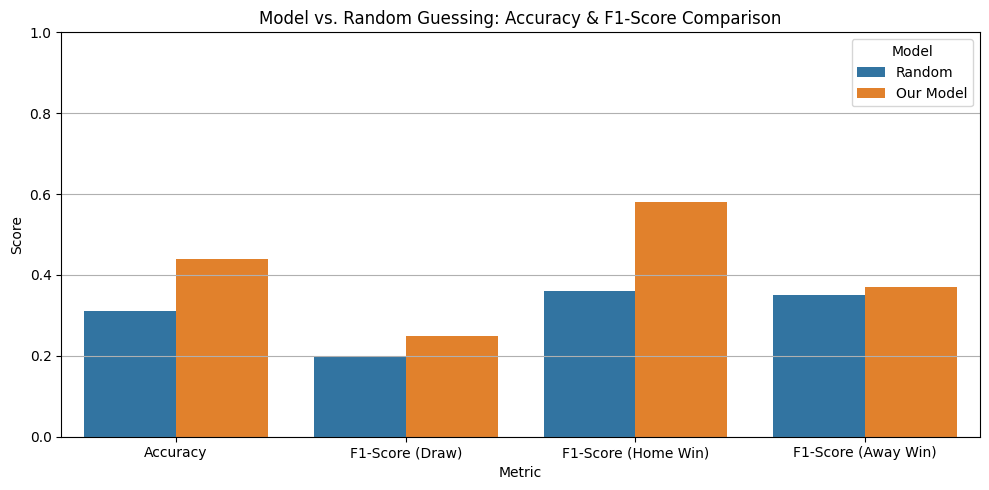

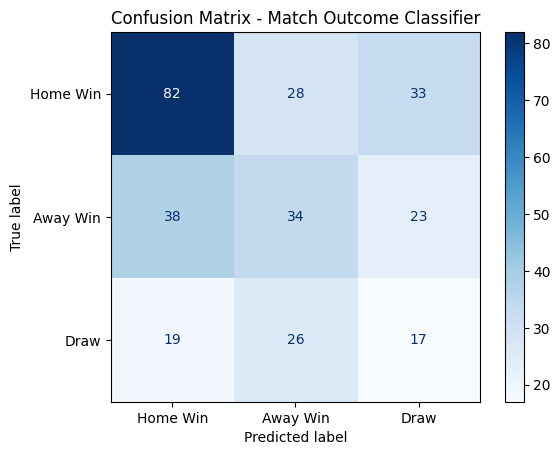

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# randomize model
true_labels = y_test.tolist()
predicted_labels = y_pred.tolist()
np.random.seed(42)
random_preds = np.random.choice(['Home Win', 'Away Win', 'Draw'], size=len(true_labels))

model_report = classification_report(true_labels, predicted_labels, output_dict=True, labels=['Home Win', 'Away Win', 'Draw'])
random_report = classification_report(true_labels, random_preds, output_dict=True, labels=['Home Win', 'Away Win', 'Draw'])

# Comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (Draw)', 'F1-Score (Home Win)', 'F1-Score (Away Win)'],
    'Random': [
        round(accuracy_score(true_labels, random_preds), 2),
        round(random_report['Draw']['f1-score'], 2),
        round(random_report['Home Win']['f1-score'], 2),
        round(random_report['Away Win']['f1-score'], 2)
    ],
    'Our Model': [
        round(accuracy_score(true_labels, predicted_labels), 2),
        round(model_report['Draw']['f1-score'], 2),
        round(model_report['Home Win']['f1-score'], 2),
        round(model_report['Away Win']['f1-score'], 2)
    ]
})

#Plot the comparison
plt.figure(figsize=(10, 5))
sns.barplot(
    data=comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score'),
    x='Metric', y='Score', hue='Model'
)
plt.title("Model vs. Random Guessing: Accuracy & F1-Score Comparison")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()
comparison_df.style.set_caption("Classifier vs Random Guessing Performance").format(precision=2)

labels = ['Home Win', 'Away Win', 'Draw']
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Match Outcome Classifier")
plt.grid(False)
plt.show()


### We are satisified with obtain results, but we will try diffrent algorithm - **XG Boost**

In [223]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

pipeline_xgb.fit(X_train, y_train_enc)

y_pred_enc = pipeline_xgb.predict(X_test)
y_pred_xgb = label_encoder.inverse_transform(y_pred_enc)
y_true = y_test.tolist() 


c:\Users\maria\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Compare XG Boost performance with previous model 

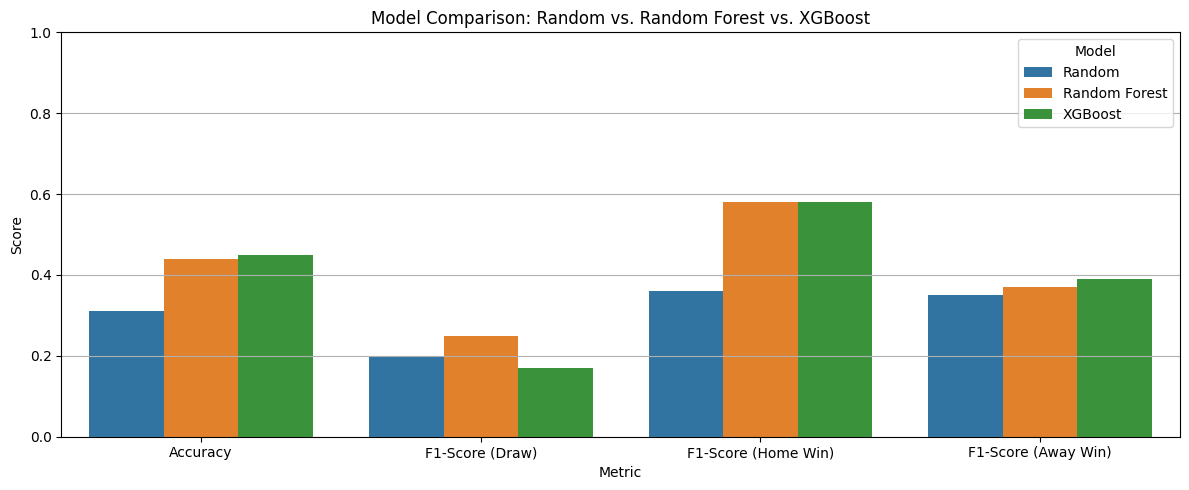

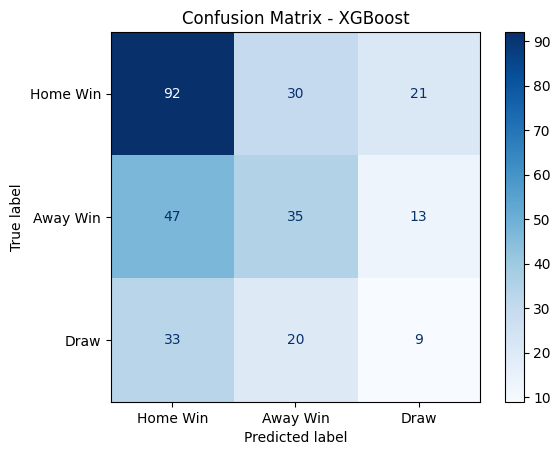

In [224]:
labels = ['Home Win', 'Away Win', 'Draw']
true_labels = y_test.tolist()

np.random.seed(42)
random_preds = np.random.choice(labels, size=len(true_labels))

random_report = classification_report(true_labels, random_preds, output_dict=True, labels=labels)
rf_report = classification_report(true_labels, y_pred, output_dict=True, labels=labels)
xgb_report = classification_report(true_labels, y_pred_xgb, output_dict=True, labels=labels)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score (Draw)', 'F1-Score (Home Win)', 'F1-Score (Away Win)'],
    'Random': [
        round(accuracy_score(true_labels, random_preds), 2),
        round(random_report['Draw']['f1-score'], 2),
        round(random_report['Home Win']['f1-score'], 2),
        round(random_report['Away Win']['f1-score'], 2)
    ],
    'Random Forest': [
        round(accuracy_score(true_labels, y_pred), 2),
        round(rf_report['Draw']['f1-score'], 2),
        round(rf_report['Home Win']['f1-score'], 2),
        round(rf_report['Away Win']['f1-score'], 2)
    ],
    'XGBoost': [
        round(accuracy_score(true_labels, y_pred_xgb), 2),
        round(xgb_report['Draw']['f1-score'], 2),
        round(xgb_report['Home Win']['f1-score'], 2),
        round(xgb_report['Away Win']['f1-score'], 2)
    ]
})

plt.figure(figsize=(12, 5))
sns.barplot(
    data=comparison_df.melt(id_vars='Metric', var_name='Model', value_name='Score'),
    x='Metric', y='Score', hue='Model'
)
plt.title("Model Comparison: Random vs. Random Forest vs. XGBoost")
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

cm = confusion_matrix(true_labels, y_pred_xgb, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.grid(False)
plt.show()


## Summary

### Dataset Description
- Match data from two seasons was used, with one for training and the other for testing.
- Team statistics were aggregated and clustered into three style categories:
  - Possession Style
  - Defense Style
  - Attack Style
- Each match was annotated with home and away team styles and labeled with the actual result.


### Models Compared
| Model            | Description                                 |
|------------------|---------------------------------------------|
| Random           | Baseline model using uniform random choice  |
| Random Forest    | Tree-based ensemble classifier with class balancing |
| XGBoost          | Gradient boosting classifier with label encoding |


### Evaluation Metrics
- Accuracy
- F1-Score per class: Draw, Home Win, Away Win
- Confusion Matrix for visualizing classification performance


### Key Findings
- XGBoost achieved the highest overall accuracy (approximately 45%).
- Random Forest also performed well, especially on Home Win predictions.
- Draws remain the most difficult class to predict
- Both models significantly outperformed random guessing.